In [3]:
# Проверка возможности использования xgbooster в основном, либо предварительно (2017-06-30)

In [4]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [5]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [6]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [7]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [521]:
binsData = 75

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
if False : # True :
    trDirI = trDirJPG
    teDirI = teDirJPG
    ttExt  = '.jpg'
else :
    trDirI = trDirTIF
    teDirI = teDirTIF
    ttExt  = '.tif'
trWork, teWork = '../Work/Train', '../Work/Test'
print (trDirI,teDirI, trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Data/train-tif-v2 ../Data/test-tif-v2 ../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [522]:
xx=os.listdir(trDirI); xx.sort(); xx[:6]

['train_0.tif',
 'train_1.tif',
 'train_10.tif',
 'train_100.tif',
 'train_1000.tif',
 'train_10000.tif']

In [523]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [524]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [525]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [526]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [527]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [595]:
def formImExt (nf, resize=(32,32), printOK=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                nx = cv.resize(ni,resize)
            if (ni.shape[2]==4) :
                #r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
                r,g,b,n = cv.resize(ni[:,:,2],resize),cv.resize(ni[:,:,1],resize),cv.resize(ni[:,:,0],resize),cv.resize(ni[:,:,3],resize)
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                nx      = np.array([r,g,b,n,dv,dw]).T; 
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

def formImHist (nf, size, printOK=False) :
    
    def hist1 (nf1,bins) :
        h,_ = np.histogram(nf1.ravel(),bins=bins)
        return h.tolist()
    
    def histN (nf,bins) :
        h = []
        for i in range(0,nf.shape[2]) :
            h = h + hist1(nf[:,:,i],bins=bins);
        return h
             
    def histNX (nf,bins) :
        h = []
        for i in range(0,nf.shape[2]) :
            h = h + hist1(nf[:,:,i],bins=bins[i]);
        return h
             
    nx = None
    try : 
        ni = cv.imread(nf,-1); #print(ni.shape)
        if (ni is not None) :
            
            if printOK : print(nf,ni.shape)

            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : 
                print('----- error ---- shape:',ni.shape,nf);
            if  ni.shape[2]==3 :
                bins = [x for x in range(0,255+int(round(256.0/size)),int(round(256.0/size)))]
                nx = histN(ni,bins)
            if  ni.shape[2]==4 : 
                bins0 = [x      for x in range(0,65535+int(round(65535.0/size)),int(round(65535.0/size)))]
                l,h,d = -16000.0,16000.0,1000.0
                bins1 = [float(x/d) for x in range(int(l),int(h+int(round((h-l)/size))), int(round((h-l)/size)))] 
                bins  = [bins0,bins0,bins0,bins0,bins1,bins1]
                r,g,b,n = ni[:,:,2], ni[:,:,1], ni[:,:,0], ni[:,:,3]
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                ni      = np.array([r,g,b,n,dv,dw]).T; 
                nx = histNX(ni,bins)
            
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [605]:
#size= 75
#bins1 =[float(x/1000.0) for x in range(-1*1000,1*1000+int(round(2000.0/size)), int(round(2000.0/size)))] 
#bins1
#75*4,trX.shape,trX[1,75*0:75*6]

In [606]:
trX, trY, i, size = [],[], 0, len(nameList)
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    nf = os.path.join(trDirI,nn+ttExt);
    nx = formImHist(nf,binsData,printOK=False)
    if (nx is not None) :
        #rr=np.save(os.path.join(trWork,nn+".npy"),nx);
        #trX.append(nn+".npy")
        trX.append(nx)
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

print(datetime.datetime.now())
trX = np.array(trX);
trY = labelList[trY];
print(len(nameList),trX.shape,trY.shape)
#trXY=pd.DataFrame(trY); trXY['name']=trX; trXY.head()
#trXY.to_pickle(os.path.join(trWork,"listFiles.pkl"))

2017-07-02 03:22:21.439046 40479 40479
2017-07-02 03:26:39.757684 	 5000 	 train_4999
2017-07-02 03:30:56.249445 	 10000 	 train_9999
2017-07-02 03:35:10.605316 	 15000 	 train_14999
2017-07-02 03:39:27.702460 	 20000 	 train_19999
2017-07-02 03:43:43.116227 	 25000 	 train_24999
2017-07-02 03:48:00.333654 	 30000 	 train_29999
2017-07-02 03:52:18.634718 	 35000 	 train_34999
2017-07-02 03:56:41.566561 	 40000 	 train_39999
2017-07-02 03:57:05.744150
40479 (40479, 450) (40479, 17)


In [607]:
trX.shape,trY.shape

((40479, 450), (40479, 17))

In [608]:
np.save('../Work/train-data-XX'+str(binsData)+ttExt+'.npy',trX)
np.save('../Work/train-data-YY'+str(binsData)+ttExt+'.npy',trY)

In [609]:
del(trX); del(trY);

In [610]:
trX = np.load('../Work/train-data-XX'+str(binsData)+ttExt+'.npy')
trY = np.load('../Work/train-data-YY'+str(binsData)+ttExt+'.npy')
print(trX.shape,trY.shape)

(40479, 450) (40479, 17)


In [657]:
# Данные для объединения от jpg
trX_TIF = np.load('../Work/train-data-XX'+str(binsData)+ttExt+'.npy')
trX_JPG = np.load('../Work/train-data-XX'+'64'+'.jpg'+'.npy')

In [658]:
trXX = np.hstack([trX_JPG,trX_TIF])
trX  = trXX
del trXX,trX_JPG,trX_TIF
trX.shape

(40479, 642)

In [659]:
import xgboost as xgb

In [660]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,1])

In [661]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

results, bstList = [], []
for i in range(trY.shape[1]) :
    print ('Working: {}'.format(i))
    dtrain.set_label(trY[:,i])
    history = xgb.cv(param, dtrain, metrics=['auc'], verbose_eval=30, num_boost_round=1000, nfold=3, early_stopping_rounds=20) #,stratified=True,maximize=True)
    results.append(history)
    rvalidCV = {}
    watchlistCV  = [(dtrain,'train')]
    bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
    bstList.append(bst)
    

Working: 0
[0]	train-auc:0.943745+0.00387279	test-auc:0.928803+0.0109092
[30]	train-auc:0.991567+0.000613583	test-auc:0.962814+0.00131396
[60]	train-auc:0.997936+4.87055e-05	test-auc:0.962957+0.00128508
[0]	train-auc:0.944489	train-rmse:0.37734
[1]	train-auc:0.956602	train-rmse:0.300831
[2]	train-auc:0.960585	train-rmse:0.250154
[3]	train-auc:0.96571	train-rmse:0.218458
[4]	train-auc:0.967427	train-rmse:0.198928
[5]	train-auc:0.970312	train-rmse:0.186327
[6]	train-auc:0.972427	train-rmse:0.178707
[7]	train-auc:0.974333	train-rmse:0.173315
[8]	train-auc:0.975141	train-rmse:0.170245
[9]	train-auc:0.975993	train-rmse:0.167947
[10]	train-auc:0.977335	train-rmse:0.166084
[11]	train-auc:0.978205	train-rmse:0.164358
[12]	train-auc:0.979457	train-rmse:0.162672
[13]	train-auc:0.980734	train-rmse:0.160686
[14]	train-auc:0.981724	train-rmse:0.159223
[15]	train-auc:0.982174	train-rmse:0.158168
[16]	train-auc:0.982992	train-rmse:0.157097
[17]	train-auc:0.983487	train-rmse:0.156353
[18]	train-auc:0.

In [662]:
# save xgb models into files
for i in range(len(bstList)) :
    bstList[i].save_model('../Work/Models/model-'+str(100+i)+'-jpg-tif-'+str(binsData)+ttExt+'.xgb')

In [615]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model('../Work/Models/model-'+str(100+i)+'-jpg-tif-'+str(binsData)+ttExt+'.xgb')
bstList = bstList0
del bstList0
len(bstList)

17

In [676]:
#[(x['test-rmse-mean'].min(),x['test-rmse-mean'].argmin()) for x in results]

In [677]:
#[(x['test-rmse-mean'].min(),x['test-rmse-mean'].argmin()) for x in results]

In [678]:
#[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 50

In [619]:
#[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 75

In [620]:
#[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 255

In [621]:
#[(x['test-auc-mean'].max(),x['test-auc-mean'].argmax()) for x in results] # 64

In [663]:
trYP = []
for bstI in bstList :
    trYP1 = bstI.predict(dtrain);
    trYP.append(trYP1)
trYP = np.array(trYP).T
type(trYP),trYP.shape

(numpy.ndarray, (40479, 17))

In [664]:
trYPP= trYP.copy() # вероятностный массив
trYP[trYP<0.5] = 0
trYP[trYP!=0]  = 1

In [665]:
accListOld = accList

In [666]:
accList = []
for i in range(trYP.shape[1]) :
    print ('#{} accuracy={} precision={} recall={} ros_auc={} fbeta2={} not={}'.format(i, 
                                           skm.accuracy_score(trY[:,i],trYP[:,i]), 
                                           skm.precision_score(trY[:,i],trYP[:,i]), 
                                           skm.recall_score(trY[:,i],trYP[:,i]), 
                                           skm.roc_auc_score(trY[:,i],trYP[:,i]), 
                                           skm.fbeta_score(trY[:,i],trYP[:,i],beta=2),
                                           len(trYP[trYP[:,i]<>trY[:,i],i])))
    accList.append((i, skm.roc_auc_score(trY[:,i],trYP[:,i]), skm.confusion_matrix(trY[:,i],trYP[:,i])))
    #fpr,tpr,thr = skm.roc_curve(trY[:,i],trYP[:,i]); print (len(thr),len(fpr),len(trYP[:,i]))
    #plt.plot(fpr,tpr); plt.show()

#0 accuracy=0.977914474172 precision=0.889753566796 recall=0.763070077864 ros_auc=0.878160416096 fbeta2=0.785436226242 not=894
#1 accuracy=0.990315966304 precision=0.992830779852 recall=0.996747794098 ros_auc=0.952858050791 fbeta2=0.995961920592 not=392
#2 accuracy=0.955680723338 precision=0.942840306423 recall=0.90946000812 ros_auc=0.942675608378 fbeta2=0.915945632084 not=1794
#3 accuracy=0.98470812026 precision=0.98425964619 recall=0.994126129929 ros_auc=0.978304764831 fbeta2=0.992137040157 not=619
#4 accuracy=0.932952889152 precision=0.913978494624 recall=0.699635676697 ros_auc=0.84243910362 fbeta2=0.734065747374 not=2714
#5 accuracy=0.965018898688 precision=0.904470079308 recall=0.685519125683 ros_auc=0.83916087738 fbeta2=0.720397381417 not=1416
#6 accuracy=0.940734701944 precision=0.897979230985 recall=0.7928385578 ros_auc=0.88520291257 fbeta2=0.811849784319 not=2399
#7 accuracy=0.934608068381 precision=0.889693356048 recall=0.466607102971 ros_auc=0.729706529098 fbeta2=0.515649684

In [667]:
[(i,cm[0,1]+cm[1,0]-(accList[i][2][1,0]+accListOld[i][2][0,1])) for i,roc,cm in accList]

[(0, -14),
 (1, -338),
 (2, -105),
 (3, -795),
 (4, -120),
 (5, -57),
 (6, -315),
 (7, -18),
 (8, 0),
 (9, -55),
 (10, -39),
 (11, 0),
 (12, -4),
 (13, 0),
 (14, 1),
 (15, 2),
 (16, 0)]

In [680]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-498)/40497.0, (40497.0-898)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((498, 17), [3, 10, 0, 9], 0.9877027927994666, 0.9778255179396005)

In [669]:
# Построение важности полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

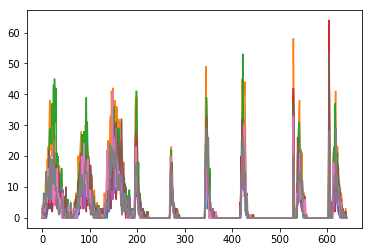

['haze',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'bare_ground']

In [670]:
xx = [0]+range(2,8)+[12] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


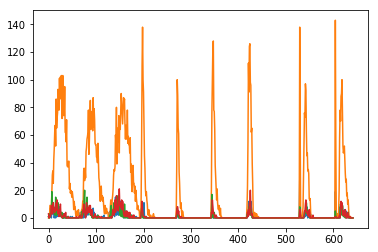

['slash_burn', 'partly_cloudy', 'blooming', 'selective_logging']

In [671]:
xx = [8,10,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


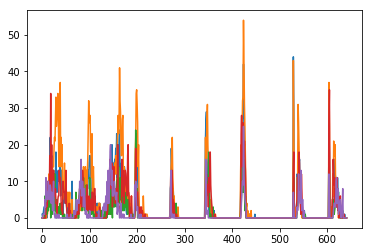

['primary', 'cloudy', 'conventional_mine', 'artisinal_mine', 'blow_down']

In [672]:
xx = [1,9,11,13,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [673]:
# Попытка посчитать уровень прохождения для каждого признака

In [674]:
ixx,iacc = [], []
for i in range(trY.shape[1]) :
    max, maxxx = 0.0, 0.0
    for xx in range(0,101) :
        tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
        tempYP[tempYP<float(xx/100.0)] = 0
        tempYP[tempYP>0.0]   = 1
        temp = skm.accuracy_score(trY[:,i],tempYP)
        #print(float(xx/10.0),temp)
        if (temp>max) : 
            max = temp; maxxx = float(xx)
            temp = skm.confusion_matrix(trY[:,i],tempYP);
            minloss = temp[0][1]+temp[1][0]
    ixx.append(maxxx)
    tempYP = trYPP[:,i].copy(); #print(tempYP.mean())
    tempYP[tempYP<0.5]   = 0
    tempYP[tempYP>0.0]   = 1
    temp = skm.accuracy_score(trY[:,i],tempYP)
    minloss05 = skm.confusion_matrix(trY[:,i],tempYP);
    minloss05 = minloss05[0][1]+minloss05[1][0]
    iacc.append((maxxx,max,temp,minloss,minloss05))
ixx
#[ixx[xx] for xx in wr]

[44.0,
 62.0,
 43.0,
 56.0,
 40.0,
 37.0,
 42.0,
 37.0,
 20.0,
 50.0,
 8.0,
 4.0,
 30.0,
 6.0,
 19.0,
 25.0,
 9.0]

In [675]:
iacc

[(44.0, 0.97895204921070189, 0.97791447417179278, 852, 894),
 (62.0, 0.99081004965537689, 0.99031596630351537, 372, 392),
 (43.0, 0.95807702759455515, 0.95568072333802712, 1697, 1794),
 (56.0, 0.98522690777934241, 0.98470812025988785, 598, 619),
 (40.0, 0.93685614763210556, 0.93295288915240004, 2556, 2714),
 (37.0, 0.96803280713456363, 0.96501889868820867, 1294, 1416),
 (42.0, 0.94216754366461619, 0.94073470194421804, 2341, 2399),
 (37.0, 0.94461325625633041, 0.93460806838113586, 2242, 2647),
 (20.0, 0.99901183329627707, 0.99666493737493511, 40, 135),
 (50.0, 0.99980236665925537, 0.99980236665925537, 8, 8),
 (8.0, 1.0, 1.0, 0, 0),
 (4.0, 1.0, 1.0, 0, 0),
 (30.0, 0.99797425825736796, 0.99503446231379233, 82, 201),
 (6.0, 1.0, 1.0, 0, 0),
 (19.0, 0.99540502482768844, 0.99340398725264956, 186, 267),
 (25.0, 0.99750487907309959, 0.99439215395637248, 101, 227),
 (9.0, 1.0, 1.0, 0, 0)]

In [502]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [636]:
nameAsk = os.listdir(teDirI); print(len(nameAsk))
trOX, trOY, i, size = [], [], 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    nf = os.path.join(teDirI,nn);
    nx = formImHist(nf,binsData) #,printOK=True)
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)

print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-07-02 04:07:37.160263 61191 61191
2017-07-02 04:11:37.513480 	 5000 	 test_15649.tif
2017-07-02 04:15:35.141539 	 10000 	 test_32423.tif
2017-07-02 04:19:31.464628 	 15000 	 test_36264.tif
2017-07-02 04:23:26.291960 	 20000 	 test_10894.tif
2017-07-02 04:27:27.294855 	 25000 	 file_9502.tif
2017-07-02 04:31:23.951498 	 30000 	 file_14128.tif
2017-07-02 04:35:20.500051 	 35000 	 file_17389.tif
2017-07-02 04:39:17.673402 	 40000 	 test_19356.tif
2017-07-02 04:43:14.361964 	 45000 	 test_10134.tif
2017-07-02 04:47:11.167835 	 50000 	 test_24243.tif
2017-07-02 04:51:12.830154 	 55000 	 test_7049.tif
2017-07-02 04:55:13.652858 	 60000 	 file_10482.tif
2017-07-02 04:56:09.780971


In [637]:
trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trOX.shape,trOY.shape)

61191 (61191, 450) (61191,)


In [638]:
#trOX[20],trOY[20]

In [639]:
# Saving & Loading

In [640]:
np.save('../Work/test-data-XX'+str(binsData)+ttExt+'.npy',trOX)
np.save('../Work/test-data-YY'+str(binsData)+ttExt+'.npy',trOY)

In [641]:
trOX = np.load('../Work/test-data-XX'+str(binsData)+ttExt+'.npy')
trOY = np.load('../Work/test-data-YY'+str(binsData)+ttExt+'.npy')
print(trOX.shape,trOY.shape)

(61191, 450) (61191,)


In [684]:
# Данные для объединения от jpg
trOX_TIF = np.load('../Work/test-data-XX'+str(binsData)+ttExt+'.npy')
trOX_JPG = np.load('../Work/test-data-XX'+'64'+'.jpg'+'.npy')

In [685]:
trOXX = np.hstack([trOX_JPG,trOX_TIF])
trOX  = trOXX
del trOXX,trOX_JPG,trOX_TIF
trOX.shape

(61191, 642)

In [686]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [687]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [688]:
np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [689]:
trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
trP.shape

(61191, 17)

In [690]:
wr = [labels.index(i) for i in weather_labels];
trM=np.array(ixx)/100.0 #np.array([0.5]*17);
#### Коэффициенты работают +0.01 к счету trM=np.array([0.5]*17);
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.62, 0.43, 2.0, 0.4, 0.37, 0.42, 0.37, 0.2, 2.0, 2.0, 0.04, 0.3, 0.06, 0.19, 0.25, 0.09]


In [691]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trA1 = [weather_labels[trP[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])]
    trPP = trA1 + trA2;
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'partly_cloudy primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.    0.62  0.43  2.    0.4   0.37  0.42  0.37  0.2   2.    2.    0.04
  0.3   0.06  0.19  0.25  0.09] [  2.89360315e-01   9.97324467e-01   9.27911252e-02   8.86523485e-01
   2.33563483e-02   1.27034227e-03   1.16532138e-02   1.36206136e-03
   1.15857008e-04   1.26739935e-04   1.59611454e-06   5.96159452e-06
   1.86576061e-02   1.35449022e-06   4.14318871e-04   2.84464797e-04
   1.24619264e-05]


In [692]:
print(labels)
print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.62, 0.43, 2.0, 0.4, 0.37, 0.42, 0.37, 0.2, 2.0, 2.0, 0.04, 0.3, 0.06, 0.19, 0.25, 0.09]


In [693]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-02-06-03-23
